# Capstone Project

In [63]:
# importing the required lib's
import requests
import pandas as pd
# !pip install beautifulsoup4
from bs4 import BeautifulSoup
import time

In [9]:
## creating an instance of the BeautifulSoup class and setup the html parser

# the URL is the given URL from wich the html code is downloaded
url = "https://kiel.fox112.de/HomePageEinsaetze"
html = requests.get(url).text
soup = BeautifulSoup(html, "html.parser")

In [11]:
print(html)

<html><head></head><body bgcolor="#FFFFFF"><FONT FACE="Arial,Verdana,Tahoma,Helvetica,Sans-serif,sans-serif" SIZE="-1"><CENTER><FONT SIZE="+2" COLOR="#0000FF"><B>Die letzten Einsätze</B></FONT><BR><BR><TABLE BORDER="0" CELLPADDING="0" CELLSPACING="0"><TR><TD><B>31.05.2024</B></TD><TD WIDTH="10"></TD><TD ALIGN="CENTER">03:13</TD><TD WIDTH="10"></TD><TD><A HREF="HomePageEinsaetzeFF.php?EVSTAT=456937120" TARGET="_blank" style="text-decoration: none"><B>FF Schilksee</B></A></TD><TD WIDTH="10"></TD><TD><A HREF="HomePageEinsaetzeFF.php?EVSTAT=456937120" TARGET="_blank" style="text-decoration: none">Brand oder Explosion</B></A></TD></TR><TR><TD><B>30.05.2024</B></TD><TD WIDTH="10"></TD><TD ALIGN="CENTER">18:50</TD><TD WIDTH="10"></TD><TD><A HREF="HomePageEinsaetzeFF.php?EVSTAT=86139890" TARGET="_blank" style="text-decoration: none"><B>FF Rönne</B></A></TD><TD WIDTH="10"></TD><TD><A HREF="HomePageEinsaetzeFF.php?EVSTAT=86139890" TARGET="_blank" style="text-decoration: none">Brand oder Explosio

In [18]:
# Extracting information directly without creating separate variables
resultDict = {
    "date":  "",
    "time": "",
    "department": "",
    "categorys": "",
}

sadly the single entries are not nicely labeled that one can access them easily
in order to extract the text from the html code in the following the columns will be extracted mit direkter ansprache der zeile in der diese vorkommen, dies ist leider nur so möglich und sehr unschön da im falle eines updates sich die spaltenverteilung ändern könnte und der programmcode angepasst werden muss.

In [70]:
def extract_table_data(html_code):
    soup = BeautifulSoup(html_code, 'html.parser')
    rows = soup.find_all('tr')[:-1]  # Exclude the last row because it includes the "weitere" button
    date, time, department, category = [], [], [], []

    for row in rows:
        column = row.find_all('td')
        date.append(column[0].get_text())
        time.append(column[2].get_text())
        department.append(column[4].get_text())
        category.append(column[6].get_text())

    df = pd.DataFrame({
    'date': date,
    'time': time,
    'department': department,
    'category': category
    })
    return df

In [73]:
more_pages = True
page = 24
data = pd.DataFrame()


while more_pages == True:
    print(f"Now scraping page {page}")
    url = f"https://kiel.fox112.de/HomePageEinsaetze.php?nextea={page}"
    html = requests.get(url).text

    data = pd.concat([data, extract_table_data(html)])

    # Checking if there are more pages to scrape using the "weitere" href with font color "#ff0000"
    if True == True:
        page += 24
    else:
        more_pages = False

    time.sleep(15) 

Now scraping page 24
Now scraping page 48
Now scraping page 72
Now scraping page 96
Now scraping page 120
Now scraping page 144
Now scraping page 168
Now scraping page 192
Now scraping page 216
Now scraping page 240
Now scraping page 264
Now scraping page 288
Now scraping page 312
Now scraping page 336
Now scraping page 360
Now scraping page 384
Now scraping page 408
Now scraping page 432
Now scraping page 456
Now scraping page 480
Now scraping page 504
Now scraping page 528
Now scraping page 552
Now scraping page 576
Now scraping page 600
Now scraping page 624
Now scraping page 648
Now scraping page 672
Now scraping page 696
Now scraping page 720
Now scraping page 744
Now scraping page 768
Now scraping page 792
Now scraping page 816
Now scraping page 840
Now scraping page 864
Now scraping page 888
Now scraping page 912
Now scraping page 936
Now scraping page 960
Now scraping page 984
Now scraping page 1008
Now scraping page 1032
Now scraping page 1056
Now scraping page 1080
Now scrapi

KeyboardInterrupt: 

### Sleeping Time

On the start page of the website, usage statistics are displayed. To prevent getting blocked, it's advisable to wait a bit before scraping the next page. Based on my observations, an average of 20 to 40 requests is typical for the website.

To avoid overloading the server and potential blocking, I recommend limiting the number of requests to 4 per minute.

![averageUsage of fox112](https://i.imgur.com/sJIyNIa.png "Average Usage")


In [77]:
# reset the index of the dataframe
data.reset_index(drop=True, inplace=True)

In [90]:
# combine date DD.MM.YYYY and time columns into a single datetime column
data['datetime'] = pd.to_datetime(data["date"] + " " + data["time"], format='%d.%m.%Y %H:%M')

# drop the date and time columns
df = data.drop(columns=['date', 'time'])

TypeError: unsupported operand type(s) for +: 'DatetimeArray' and 'str'

In [99]:
# make to category data type
df['category'] = df['category'].astype('category')
df["department"] = df["department"].astype('category')

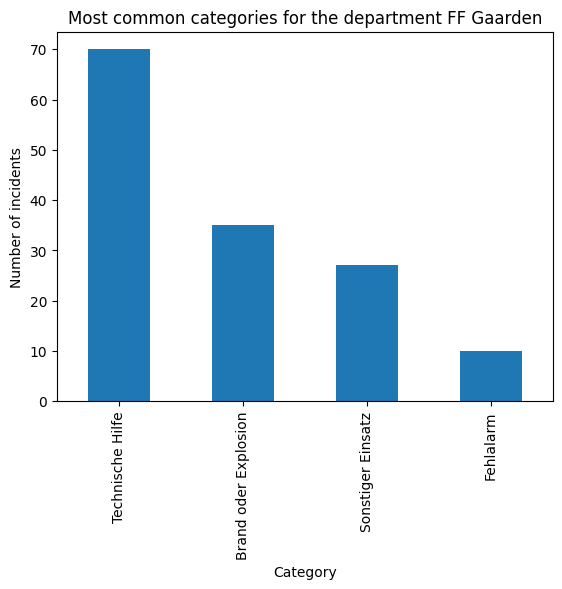

In [107]:
import matplotlib.pyplot as plt

# plot the most common categories for the department "FF Gaarden"
ax = df[df["department"] == "FF Gaarden"]["category"].value_counts().plot(kind='bar')
ax.set_title("Most common categories for the department FF Gaarden")
ax.set_ylabel("Number of incidents")
ax.set_xlabel("Category")
plt.show()


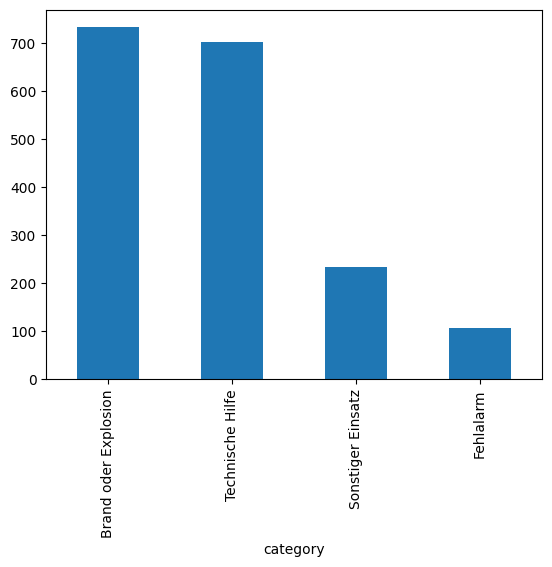

In [108]:
# plot the most common categories
ax = df["category"].value_counts().plot(kind='bar')

In [110]:
df["category"].unique()

['Brand oder Explosion', 'Technische Hilfe', 'Sonstiger Einsatz', 'Fehlalarm']
Categories (4, object): ['Brand oder Explosion', 'Fehlalarm', 'Sonstiger Einsatz', 'Technische Hilfe']

/tmp/ipykernel_26941/1235465376.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["year", "week", "category"]).size().unstack().plot(kind='line', figsize=(15, 10))


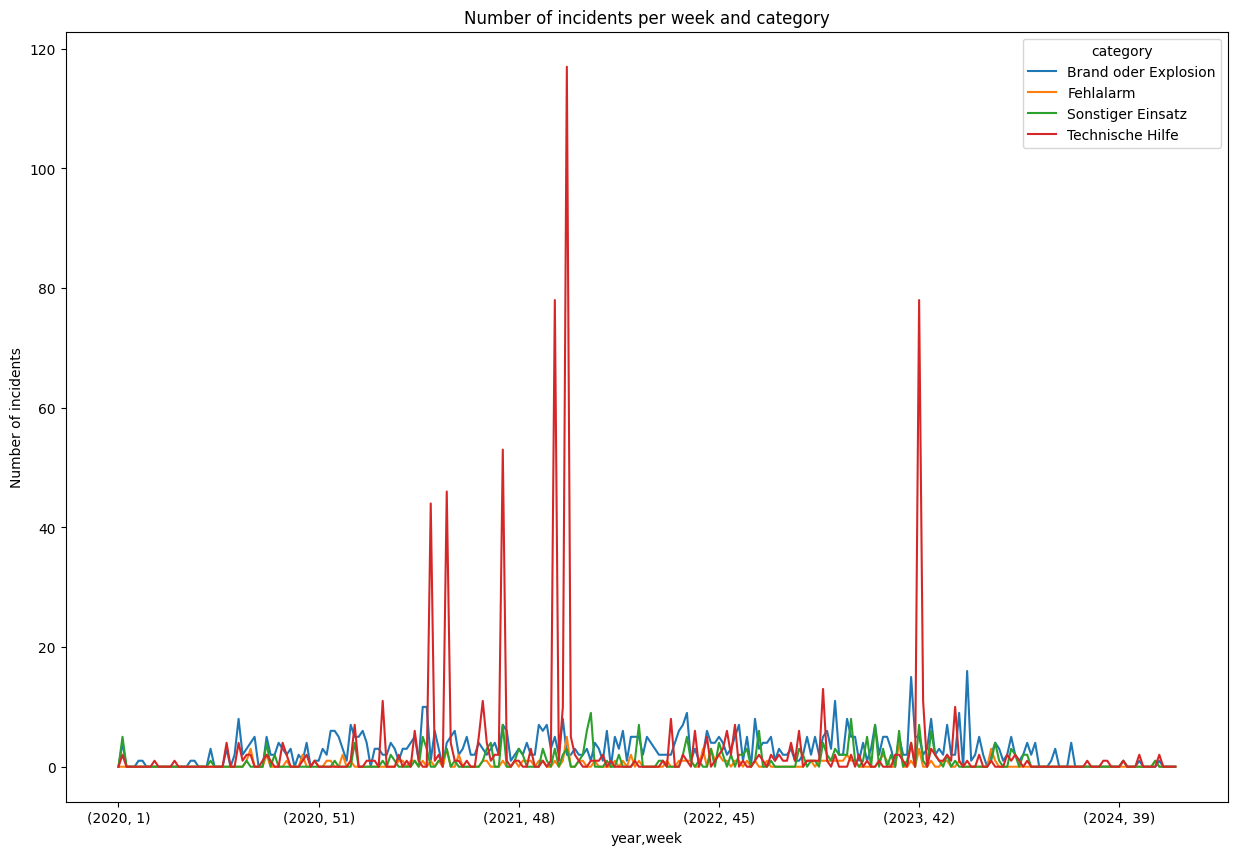

In [113]:
# plot a time series of the number of incidents per week and category as color

df["week"] = df["datetime"].dt.isocalendar().week
df["year"] = df["datetime"].dt.year

df.groupby(["year", "week", "category"]).size().unstack().plot(kind='line', figsize=(15, 10))
plt.title("Number of incidents per week and category")
plt.ylabel("Number of incidents")
plt.show()


# also consider this for the Berufsfeuerwehr

different url: https://bf-kiel.fox112.de/SSL.php